In [7]:
from sklearn.neighbors import KNeighborsClassifier

# Домашнее задание

Работаем с датасетом про дорожные знаки.

https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed/data

В первых двух задачах берем только файл train.pickle и можно подгрузить labels_names.csv

Данные можно прочитать через `pd.read_pickle`

## Easy

Скачать датасет, обучить логистическую регрессию, измерить качество.

Текстом кратко обосновать какую метрику выбираем и почему такую.

Какой вид дорожных знаков модель путает чаще всего?

## Medium

Обучить и сравнить между собой:

- логистическая регрессия
- kNN
- НБК
- SVM (попробовать 3 разных ядра)

Какая модель отработала лучше, а какая хуже всех?

Проинтерпретируйте почему худшая модель именно эта.

## Hard

Вы - ML-инженер в команде беспилотных автомобилей! Ваша следующая цель - сделать алгоритм, который будет распознавать дорожные знаки. Другая команда уже позаботилась о подготовке данных - вам приходят обрезанные картинки 32х32. Но есть проблема - разметка стоит денег, у проекта есть бюджетные ограничения, но вам готовы выделить тот бюджет, который вы сможете обосновать.

Определите сколько и каких семплов данных необходимо для того, чтобы обучить достаточно хороший алгоритм.

**Подсказка:** При анализе изображений обычно делают специальную предобработку - картинки крутят-вертят, по-разному меняют цвета. Рядом с данными лежит питоновский скрипт, может быть он поможет уменьшить необходимое количество семплов?

In [1]:
# Для интерпретируемости результатов зафиксируем:
random_seed = 42

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [3]:
filepath = '../data/train.pickle'
df = pd.read_pickle(filepath)
y = df['labels']
x = df['features']

In [4]:
labels_names = pd.read_csv('../data/label_names.csv')
df_labels_names = pd.DataFrame(labels_names)
df_labels_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


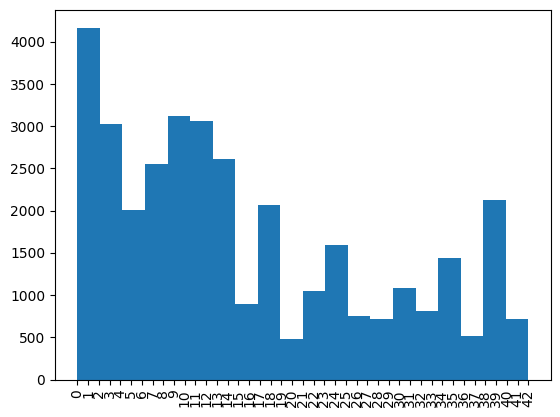

In [6]:
# Посмотрим на распределения классов. Наблюдаем сильный дисбаналс(например, между 0 и 20 классом). Поэтому метрика 
# accuracy не будет показательной.

plt.hist(y, bins=20)
plt.xticks(list(range(43)), rotation=90)
plt.show()

In [7]:
# Разделим на train и test в пропорции 75 на 25 так, чтобы в обоих выборках встречались 'одинаково' все 43 класса
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

In [8]:
# Нормализуем данные
x_train_normalized = (x_train - x_train.mean()) / x_train.std()
x_test_normalized = (x_test - x_test.mean()) / x_test.std()

In [9]:
# Преобразуем x_train и x_test в двумерные массивы(каждую картинку-матрицу развернем в вектор)
x_train_flattened = x_train_normalized.reshape(x_train_normalized.shape[0], -1) 
x_test_flattened = x_test_normalized.reshape(x_test_normalized.shape[0],-1)

In [10]:
# Обучим модель с max_iter = 100
model = LogisticRegression(random_state=random_seed, max_iter=100)
model.fit(x_train_flattened, y_train)
y_pred = model.predict(x_test_flattened)

/home/anastasia/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Для начала посмотрим матрицу ошибок:
df_confusion = confusion_matrix(y_test, y_pred)
print(df_confusion)

[[ 38   6   0 ...   0   0   0]
 [  1 466  12 ...   0   0   0]
 [  0  15 460 ...   0   0   0]
 ...
 [  0   0   0 ...  74   0   0]
 [  0   0   0 ...   0  47   2]
 [  0   0   0 ...   0   0  50]]


<Figure size 5000x5000 with 0 Axes>

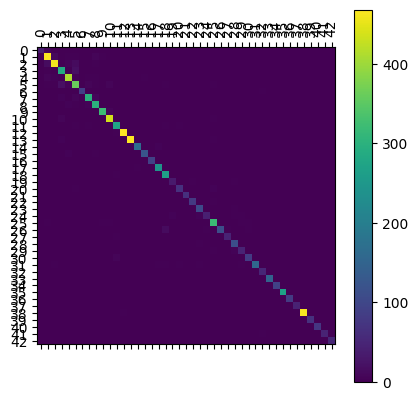

In [12]:
plt.figure(figsize=(50, 50))
plt.matshow(df_confusion)
plt.colorbar()
tick_marks = np.arange(len(df_confusion))
plt.xticks(tick_marks, rotation=90)
plt.yticks(tick_marks)
    #plt.tight_layout()
plt.show()

In [13]:
# Для начала посчитаем accuracy(непоказательная метрика, так как, скорее всего, не предсказыавет редко встречающийся класс, 
# но если и она плохая, то что-то не так)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9437931034482758

In [14]:
# посчитаем balanced_accuracy. Эта метрика считается как сумма по k отношений кол-ва правильных предсказаний класса k  
# и кол-ва элементов класса k - тем самым учитываются уже и редко встречающиеся классы.
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
balanced_accuracy

0.9305971265467051

In [15]:
# Посчитаем precision, recall, f_1 с различными усреднениями

# В качестве основной и самой показательной метрики я бы выбрала f_1 с усреднением macro.
# f1 - так как учитвает одновременно и precision, и recall.
# macro усреднение - так как считаем precision, recall для каждого классификатора отдельно, а потом усредняем.
precision_weighted = precision_score(y_test, y_pred, average = 'weighted')
precision_micro = precision_score(y_test, y_pred, average = 'micro')
precision_macro = precision_score(y_test, y_pred, average = 'macro')

metrics = {
    'precision_weighted': precision_score(y_test, y_pred, average = 'weighted'),
    'precision_micro': precision_score(y_test, y_pred, average = 'micro'),
    'precision_macro': precision_score(y_test, y_pred, average = 'macro'),
    'recall_weighted': recall_score(y_test, y_pred, average = 'weighted'),
    'recall_micro': recall_score(y_test, y_pred, average = 'micro'),
    'recall_macro': recall_score(y_test, y_pred, average = 'macro'),
    'f1_micro': f1_score(y_test, y_pred, average = 'micro'),
    'f1_macro': f1_score(y_test, y_pred, average = 'macro'),
    'f1_weighted': f1_score(y_test, y_pred, average = 'weighted')
}

for key, value in metrics.items():
    print(f'{key}: {value}')

precision_weighted: 0.9442329245976169
precision_micro: 0.9437931034482758
precision_macro: 0.9401583841474278
recall_weighted: 0.9437931034482758
recall_micro: 0.9437931034482758
recall_macro: 0.9305971265467051
f1_micro: 0.9437931034482758
f1_macro: 0.9344955512800464
f1_weighted: 0.943588207421544


In [16]:
# Чтобы понять, какой вид знаков модель распознает хуже всего, выведем класс с минимальным f1_score
# f1_none содержит f1_score посчитанный для каждого класса в интерпретации one vs all
f1_none = f1_score(y_test, y_pred, average = None)
min_index = np.argmin(f1_none)
df_labels_names['SignName'][min_index]

'Road narrows on the right'

In [17]:
# Обучим Knn
classifier = KNeighborsClassifier()
classifier.fit(x_train_flattened, y_train)
y_pred_knn = classifier.predict(x_test_flattened)
f1_macro = f1_score(y_test, y_pred_knn, average = 'macro')
f1_macro

0.878943746254735

In [18]:
# Для Наивного Байесовского классификатора используем min_max нормировку с feature_range=(0, 1)
# чтобы не было отриц значений
x_test_flattened_normalized = minmax_scale(x_test_flattened)
x_train_flattened_normalized = minmax_scale(x_train_flattened)

In [19]:
classifier_Bayes = MultinomialNB()
classifier_Bayes.fit(x_train_flattened_normalized, y_train)
y_pred_bayes = classifier_Bayes.predict(x_test_flattened_normalized)
f1_macro = f1_score(y_test, y_pred_bayes, average = 'macro')
f1_macro

0.32871795873728255

In [72]:
# Обучим SVM, метрика так же f_1 macro

for kernel in ['linear', 'poly', 'rbf']:
    model_svc = SVC(kernel=kernel, random_state = random_seed, max_iter=100)
    model_svc.fit(x_train_flattened_normalized, y_train)
    y_pred_svc = model_svc.predict(x_test_flattened_normalized)
    print(kernel, f1_score(y_test, y_pred_svc, average = 'macro'))

/home/anastasia/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


linear 0.8188121618280971


/home/anastasia/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


poly 0.2730416546270209


/home/anastasia/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


rbf 0.6038472119292808


In [20]:
# Выводы:
# 1)Лучшего всего отработала логистическая регрессия, так как она дает наилучшие метрики на данных, которые линейно разделимы.
# 2)Xуже всего отработало poly- SVM. Так как linear SVM отработало хорошо, можем сделать вывод, что данные
# хорошо разделяются гиперплоскостью, и соответственно, плохо разделаются чем-то нелинейным.
# 3) Не сильно лучше, чем poly SVM отработал наивный Байесовский классификатор.
# Объяснение: Для наивного Байесовского классификатора мы предполагаем, что признаки попарно независимы для каждого
# объекта обучающей выборки
# Но в данном случае признаки объекта обучающей выборки - это цвета 32*32*3 пикселей у изображения. Понятно, что точно есть зависимость и 
# достаточно сильная - например, если отдельно взятый пиксель белый, то и n пикселей вокруг будут скорее всего белыми
# следовательно, он будет работать очень плохо